<h1>Table of contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-description" data-toc-modified-id="Project-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project description</a></span></li><li><span><a href="#Data-description" data-toc-modified-id="Data-description-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data description</a></span></li><li><span><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data pre-processing</a></span><ul class="toc-item"><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Creating-features" data-toc-modified-id="Creating-features-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Creating features</a></span></li><li><span><a href="#Splitting-dataset" data-toc-modified-id="Splitting-dataset-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Splitting dataset</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Facebook-Prophet" data-toc-modified-id="Facebook-Prophet-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Facebook Prophet</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Checking-best-model-on-the-test-set" data-toc-modified-id="Checking-best-model-on-the-test-set-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Checking best model on the test set</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

#  Forecasting taxi demand

## Project description

**Brief information:** online taxi service plans to predict the number of taxi orders for the next hour to schedule more drivers during peak hours.

**Objective:** develop a machine learning model for predicting the number of orders for the next hour, allocating peak hours.

**Tasks:** analyze the given time series data, determine peak hours, and consider several models with hyperparameter optimization on the training set. The overall RMSE metric should be less than 48 on the test set.

## Data description

* `datetime` - column containing information about the date of the order;
* `num_orders` - column with the number of ordered taxis.

## Data pre-processing

In [1]:
!pip install -q optuna
!pip install -q lightgbm
!pip install -q catboost
!pip install -q prophet

In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna
import time
import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from optuna.samplers import TPESampler

In [3]:
#reading the dataset and parsing dates
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


We can see that our time window is characterized by 10-minute intervals. Also, there are no missing values in the dataset. 

Since the task is to predict the number of taxi orders for the next hour, the time interval needs to be resampled into a period equal to 1 hour. We are also interested in the total number of orders for a time given period, so we take the orders sum.

In [6]:
#sorting dates in ascending order 
data.sort_index(inplace=True)

In [7]:
#total number of orders per 1 hour
data = data.resample('1H').sum()

In [8]:
#resampling check
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


The next step is to check our dataset for monotony.

In [9]:
data.index.is_monotonic

True

In [10]:
print(f'First observation: {data.index.min()}')
print(f'Last observation: {data.index.max()}')

First observation: 2018-03-01 00:00:00
Last observation: 2018-08-31 23:00:00


In [11]:
print(f'The timedelta is: {data.index.max() - data.index.min()}')

The timedelta is: 183 days 23:00:00


### Conclusions

* **A quick data analysis shows that the original dataset is characterized by 10-minute intervals. Considering that the task is to predict the number of taxi orders for the next hour, the data has been resampled into 1-hour intervals with the sum of orders for each hour;**
* **There are no missing values in the dataset and the data are monotonous. The first observation is on March 1, 2018, and the last one is on August 31 of the same year. The time delta is 183 days and 23 hours.**

## EDA

First, let's analyze our volume indicator (number of orders) over time and create a graph.

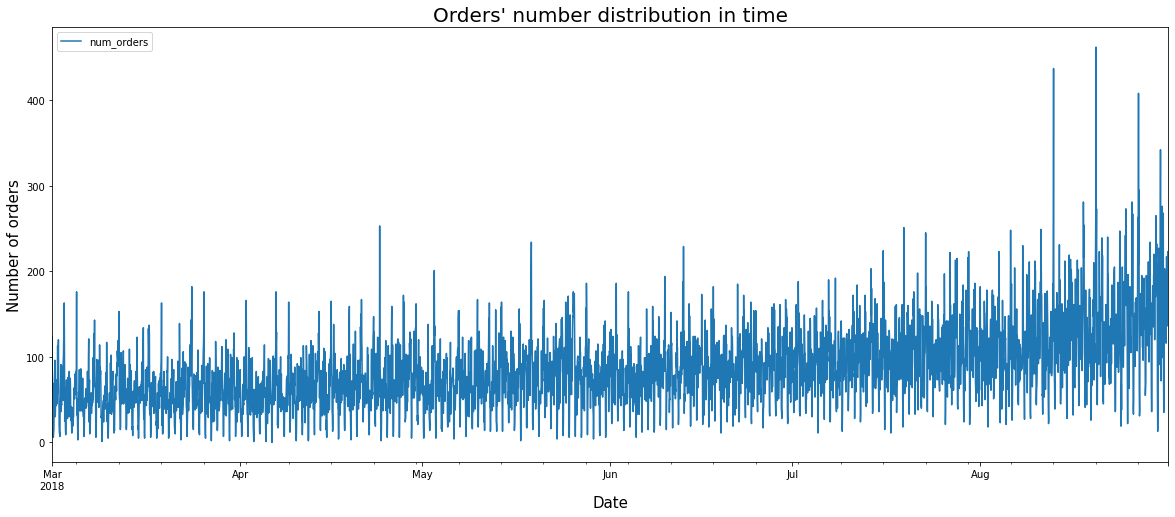

In [12]:
data.plot(figsize=(20,8))
plt.title("Orders' number distribution in time", fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of orders', fontsize=15);

The time series plot shows a slightly increasing trend toward the end of the observation period, but it is impossible to determine the trend and seasonality pattern. The next step is to look at how the trend is changing by calculating the moving average.

In [13]:
#const. and a list of periods measured in hours
DAY = 24
WEEK = DAY*7
MONTH = WEEK*4

seasonality = [DAY, WEEK, MONTH]

In [14]:
#plotting function of moving average and initial dataset (dataframe and window size as arguments)
def movavg_plot(series, size):
    moving_avg = series.rolling(window=size).mean()
    #moving average plot
    plt.figure(figsize=(20,6))
    plt.plot(moving_avg, 'r', label='Moving average')
    plt.title(f'Moving average for window size {size}', fontsize=20)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Number of orders', fontsize=15)
    #initial dataset plot
    plt.plot(series, label='Initial data', alpha=.5)
    plt.legend()

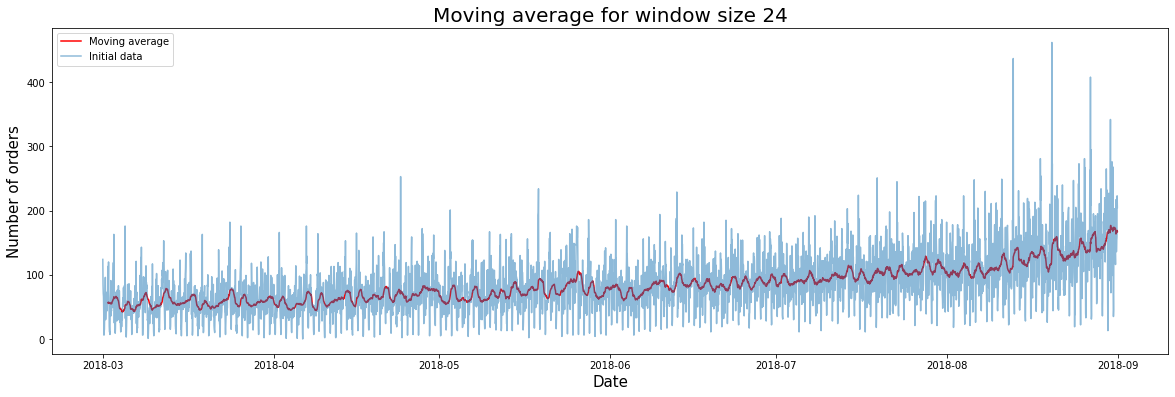

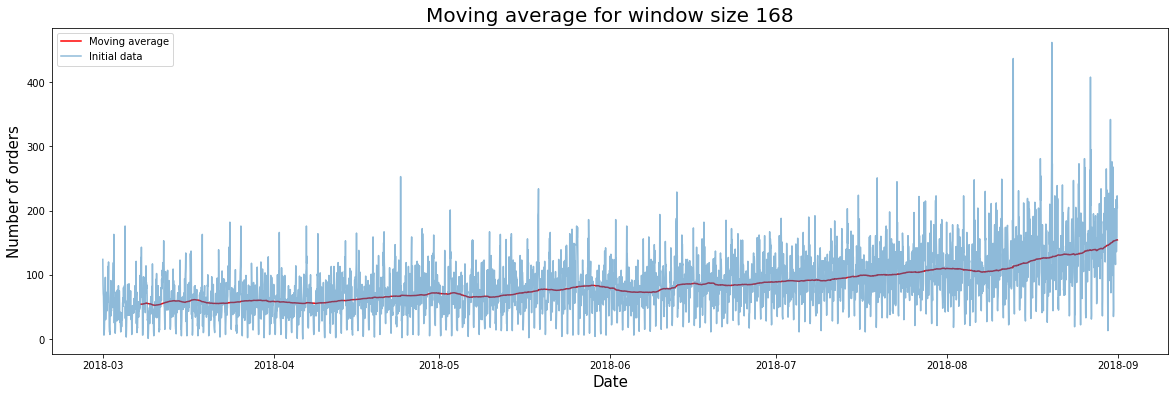

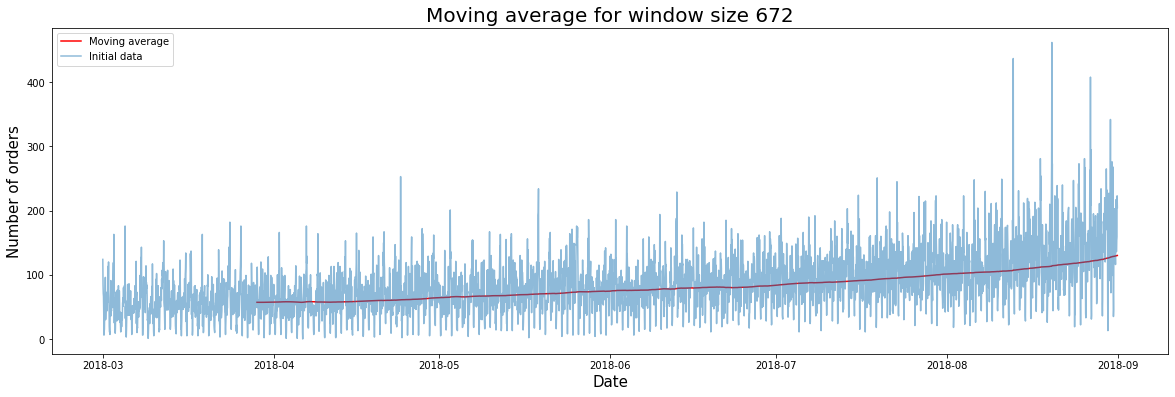

In [15]:
for _ in seasonality:
    movavg_plot(data, _)

The moving average lines clearly show the upward trend in airport taxi bookings. To determine the seasonal component, let's decompose the series into components. The series is characterized as an additive series.

In [16]:
#components plotting function (period's start and finish as arguments, default resampling - 1 hour)
def seasonality_plot(section_start, section_fin, res='1H'):
    decomposed_daily = seasonal_decompose(data.resample(res).sum(), model='additive')
    plt.figure(figsize=(15, 10))

    plt.subplot(311)
    decomposed_daily.trend[section_start:section_fin].plot(ax=plt.gca())
    plt.title('Trend')
    plt.xlabel('Date')

    plt.subplot(312)
    decomposed_daily.seasonal[section_start:section_fin].plot(ax=plt.gca()) 
    plt.title('Seasonal component')
    plt.xlabel('Date')

    plt.subplot(313)
    decomposed_daily.resid[section_start:section_fin].plot(ax=plt.gca()) 
    plt.title('Residuals')
    plt.xlabel('Date')

    plt.tight_layout()

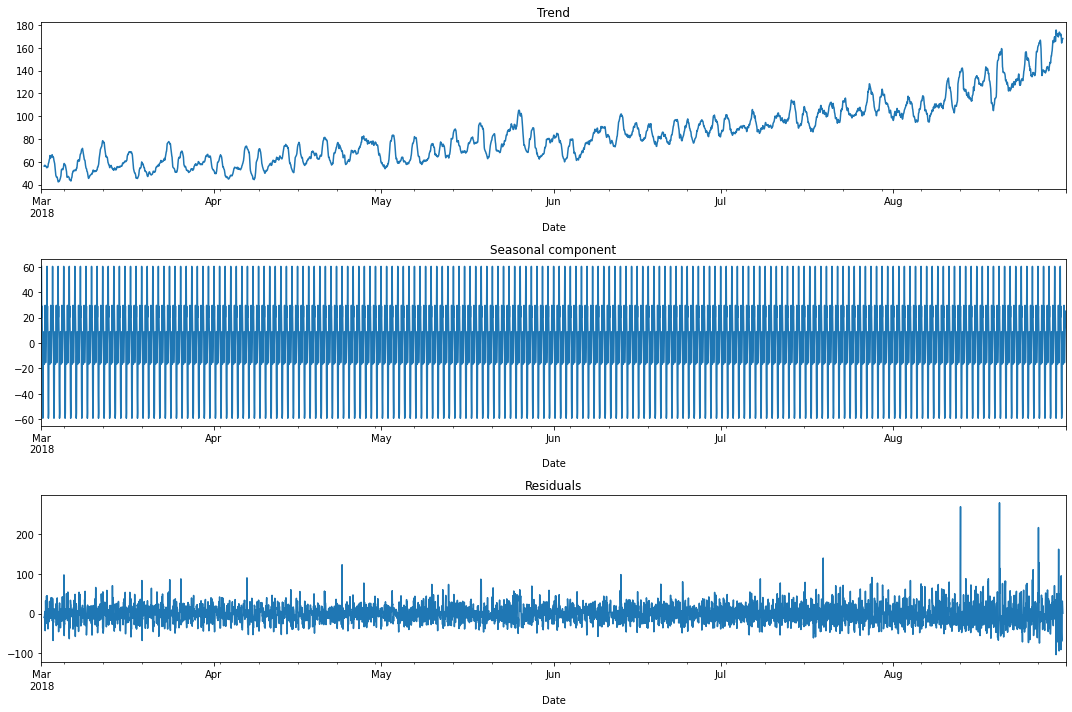

In [17]:
seasonality_plot(section_start='2018-03-01', section_fin='2018-08-31')

The seasonal decomposition confirms the thesis of a growing trend. It is difficult to determine the monthly seasonality for the data presented, as the observations are only available from March to August 2018. And for the full decomposition, it is necessary to have two complete cycles. However, there may be weekly and daily seasonality - let's dive into it.

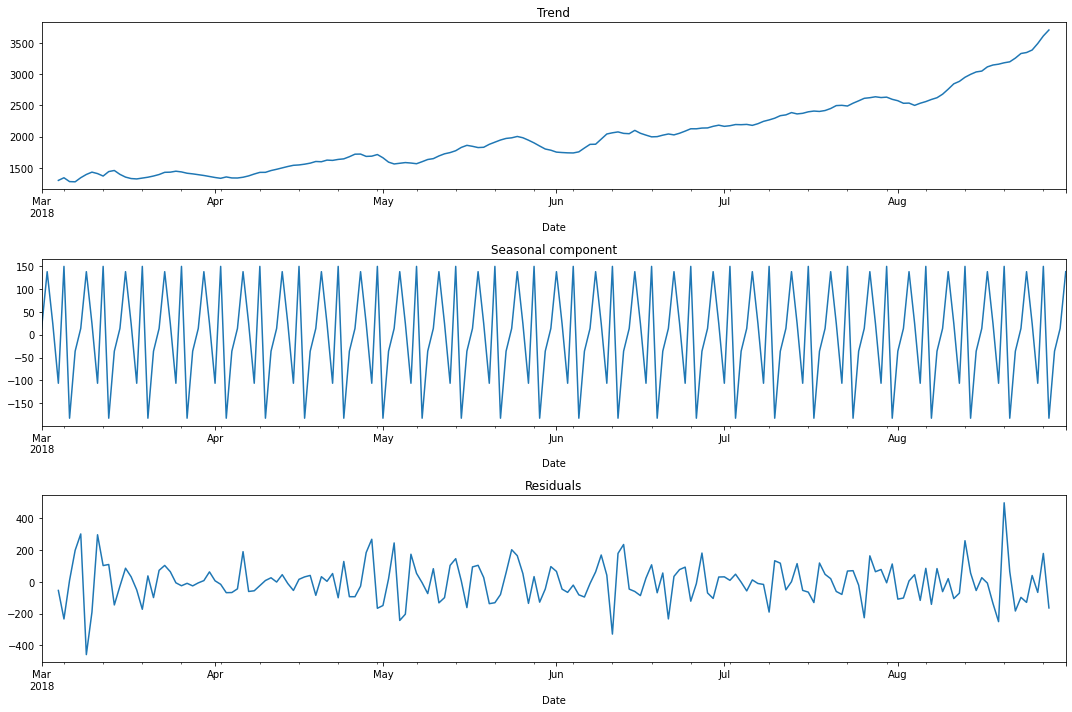

In [18]:
seasonality_plot(section_start='2018-03-01', section_fin='2018-08-31', res='1D')

For a more accurate determination of weekly seasonality, the time period should be limited.

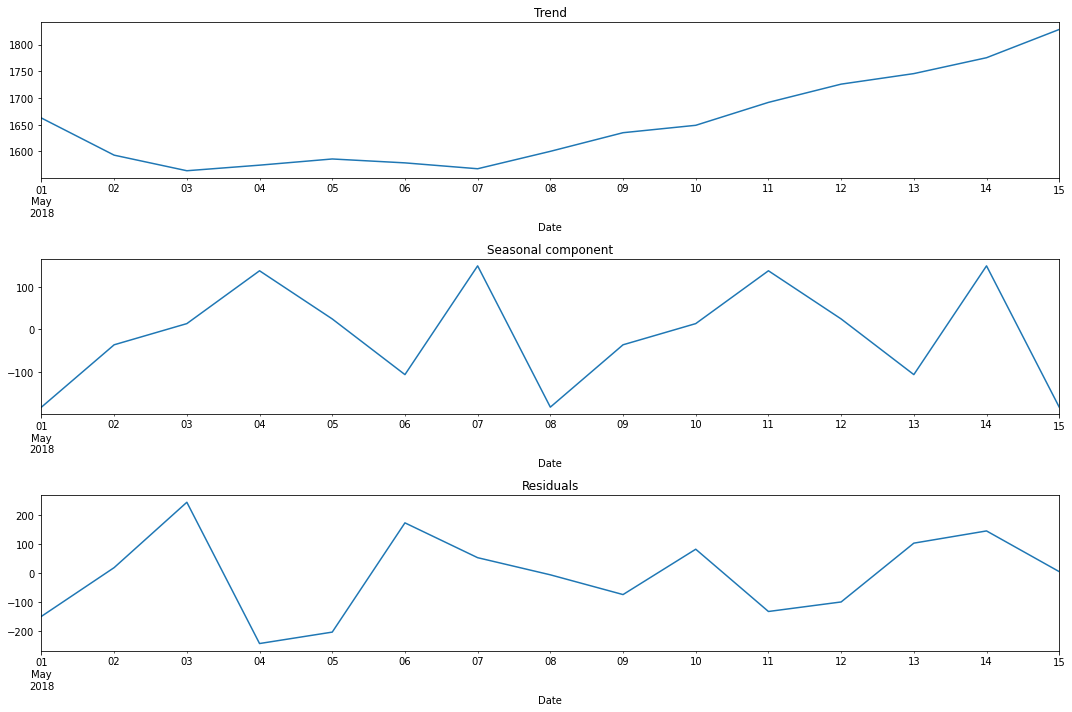

In [19]:
#decomposing first 15 days in May
seasonality_plot(section_start='2018-05-01', section_fin='2018-05-15', res='1D')

The graph clearly shows the weekly seasonality in the observations. The peak occurs at the end of the week (Friday) and the beginning of the week (Monday). For a daily seasonality analysis, the period should be limited to the first days of May, for example.

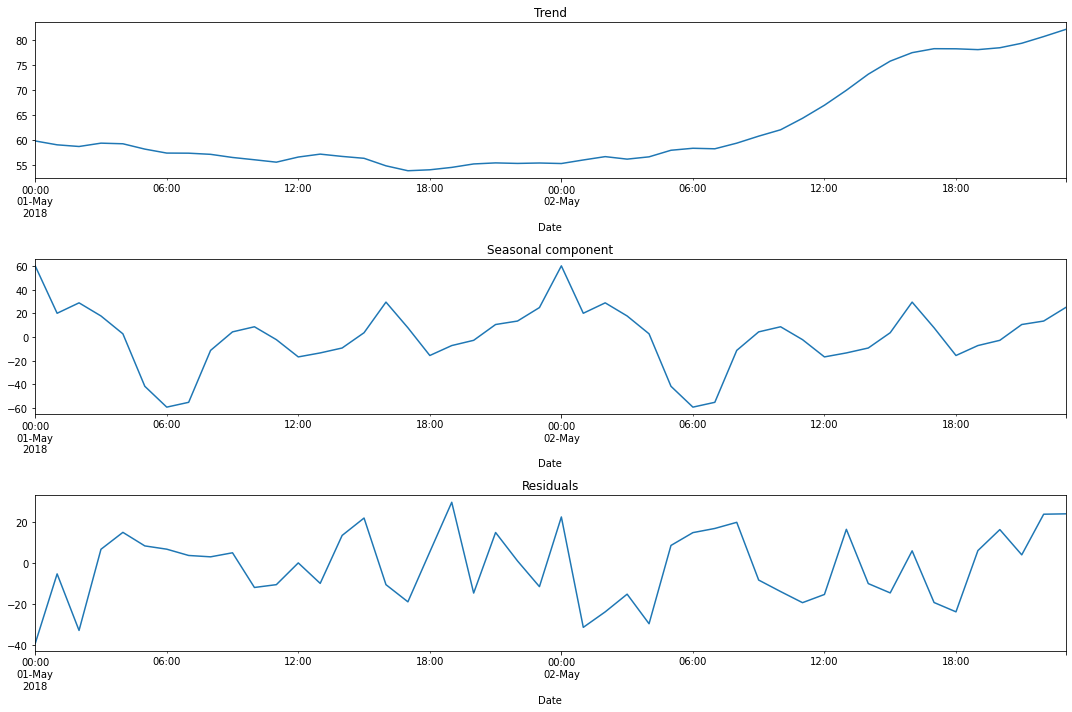

In [20]:
#decomposing first 2 days in May
seasonality_plot(section_start='2018-05-01', section_fin='2018-05-02')

Based on the daily seasonality analysis, there are clear patterns of low order numbers from midnight to ~6 am. From 6 am to midnight, the growth in taxi orders begins with peaks around 9:00 am, 4:00 pm, and midnight.

Let's check the series for stationarity to determine the possibility of further modeling and forecasting.

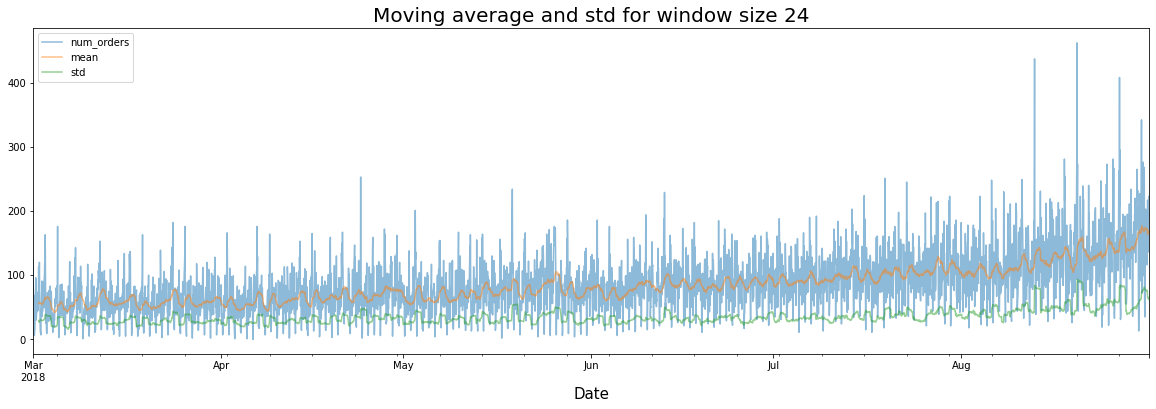

In [21]:
plt.figure(figsize=(20, 6))
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data.plot(ax=plt.gca(), alpha=.5)
plt.title('Moving average and std for window size 24', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.show()

There is a slight increase in the mean and standard deviation. Let's analyze the shift in the time series.

In [22]:
data.drop(['mean', 'std'], inplace=True, axis=1)

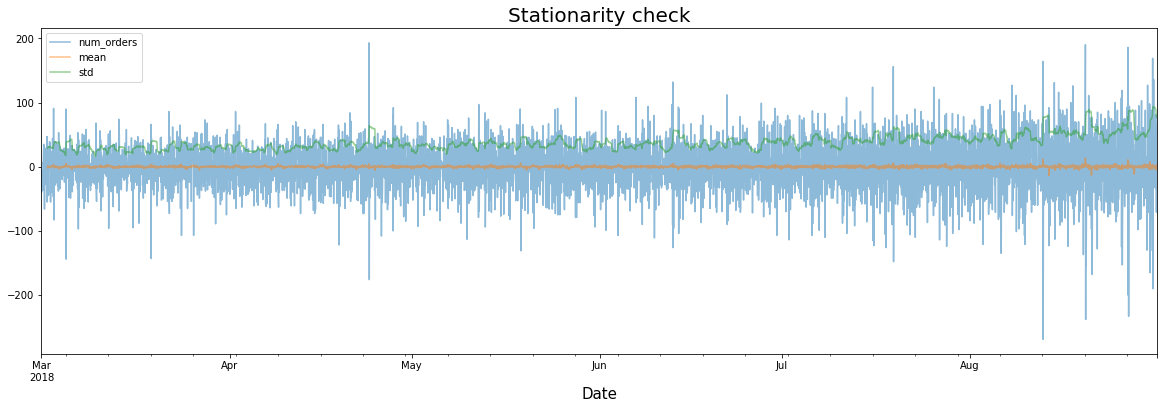

In [23]:
data_shifted = data.copy()
plt.figure(figsize=(20, 6))
data_shifted['num_orders'] = data_shifted - data_shifted.shift()
data_shifted['mean'] = data_shifted['num_orders'].rolling(24).mean()
data_shifted['std'] = data_shifted['num_orders'].rolling(24).std()
data_shifted.plot(ax=plt.gca(), alpha=.5)
plt.title('Stationarity check', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.show()

Small fluctuations in the standard deviation and the moving average indicate that the series has become stationary. In this respect, the data is suitable for modeling and forecasting. First, let's create features and remove the mean and standard deviation columns.

### Creating features

Since we have daily and weekly seasonality in our observations, it makes sense to include the hour and day of the week as features. The model should also include lagging values and moving averages to capture the trends and dependencies on previous observations.

In [24]:
#features creating function (df, lag and windows size as arguments)
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour.astype('category')
    data['day_of_week'] = data.index.dayofweek.astype('category')
    
    
    for lag in range(1, max_lag):
        i = 0
        if lag <=24:
            data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
            i += 1
        else:
            for _ in range(i+24, max_lag+1, 24):
                data['lag_{}'.format(_)] = data['num_orders'].shift(_)
                
    for mean_size in range(24, rolling_mean_size+1, 24):
        data['smavg_{}'.format(mean_size)] = data['num_orders'].shift().rolling(mean_size).mean()

In [25]:
make_features(data, 168, 168)

In [26]:
data.head()

,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_120,lag_144,lag_168,smavg_24,smavg_48,smavg_72,smavg_96,smavg_120,smavg_144,smavg_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Splitting dataset

In [27]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Conclusions

* **Throughout the research horizon (March 2018-August 2018), there is a trend towards an increase in the volume of orders at airports. The decomposition of the series into components confirms the thesis of a growing trend. Taxi order volumes are characterized by weekly and daily seasonality. Thus, peaks occur at the end of the week (Friday) and the beginning of the week (Monday), and order volumes decline from midnight to ~6 am. From about 6 am to midnight, the growth of taxi orders begins, with peaks around 9:00 am, 4:00 pm, and midnight;**
* **The following features were created: hour of the order and day of the week because the data contains daily and weekly seasonalities, lagging and moving averages values.**

## Modelling

### Linear regression

In [28]:
#timeseries cross-validation
cv_ts = TimeSeriesSplit(n_splits=3)

In [29]:
#category columns encoder
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(),
    make_column_selector(dtype_include='category')
    ),
    remainder="passthrough"
    )

#linear regression pipe
lr_pipe = Pipeline(steps=[('preprocessor', one_hot_encoder), ('lr', LinearRegression(n_jobs=-1))])

scores = cross_val_score(lr_pipe, features_train, target_train, scoring='neg_root_mean_squared_error', cv=cv_ts).mean()*-1
print(f'RMSE on cv: {scores}')

RMSE on cv: 22.715211394861484


In [30]:
lr_pipe.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9eda65bbe0>)])),
                ('lr', LinearRegression(n_jobs=-1))])

In [31]:
predictions_lr_train = lr_pipe.predict(features_train)

In [32]:
print(f'RMSE on training set: {mean_squared_error(target_train, predictions_lr_train, squared=False)}')
print(f'MAE on training set: {mean_absolute_error(target_train, predictions_lr_train)}')

RMSE on training set: 20.631928457208947
MAE on training set: 15.32976491490102


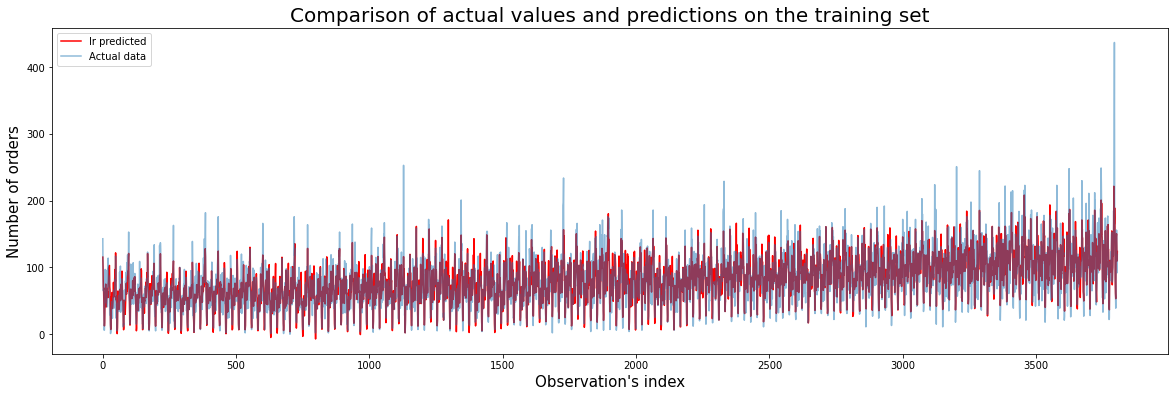

In [33]:
plt.figure(figsize=(20,6))
plt.plot(predictions_lr_train, 'r', label='lr predicted')
plt.title('Comparison of actual values and predictions on the training set', fontsize=20)
plt.xlabel("Observation's index", fontsize=15)
plt.ylabel('Number of orders', fontsize=15)
#actual data plot
plt.plot(target_train.values, label='Actual data', alpha=.5)
plt.legend();

### LGBM

In [34]:
%%time
#model creating function, hyperparameters tuning with optuna
def objective_lgb(trial):
    
    param = { 
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 42,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1)
    }
    model = LGBMRegressor(**param) 
    
    scores = cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=cv_ts) 
   
    return scores.mean()

sampler = TPESampler(seed=42) #fixed sampler for optuna
optuna.logging.set_verbosity(optuna.logging.INFO)
study_lgb = optuna.create_study(direction='maximize', sampler=sampler)
study_lgb.optimize(objective_lgb, n_trials=30)

#best tuned model
optimised_lgb = LGBMRegressor(max_depth=study_lgb.best_params['max_depth'], num_leaves=study_lgb.best_params['num_leaves'],
                                     learning_rate = study_lgb.best_params['learning_rate'], boosting_type='gbdt', random_state=42, n_jobs=-1, 
                                     objective='regression', metric='rmse')

#fitting best model
optimised_lgb.fit(features_train, target_train)

[I 2023-02-09 08:49:05,351] A new study created in memory with name: no-name-5f8488e4-d2e8-4d39-bd4c-ccd04673c8b9
[I 2023-02-09 08:49:08,128] Trial 0 finished with value: -23.091515019279075 and parameters: {'max_depth': 4, 'num_leaves': 476, 'learning_rate': 0.07587945476302646}. Best is trial 0 with value: -23.091515019279075.
[I 2023-02-09 08:49:15,122] Trial 1 finished with value: -24.065189968564187 and parameters: {'max_depth': 6, 'num_leaves': 79, 'learning_rate': 0.02403950683025824}. Best is trial 0 with value: -23.091515019279075.
[I 2023-02-09 08:49:17,667] Trial 2 finished with value: -24.491930659095043 and parameters: {'max_depth': 1, 'num_leaves': 434, 'learning_rate': 0.0641003510568888}. Best is trial 0 with value: -23.091515019279075.
[I 2023-02-09 08:49:23,569] Trial 3 finished with value: -23.463625014953266 and parameters: {'max_depth': 8, 'num_leaves': 11, 'learning_rate': 0.0972918866945795}. Best is trial 0 with value: -23.091515019279075.
[I 2023-02-09 08:49:33

CPU times: user 58.2 s, sys: 591 ms, total: 58.8 s
Wall time: 45.9 s


LGBMRegressor(learning_rate=0.04993807526031365, max_depth=3, metric='rmse',
              num_leaves=249, objective='regression', random_state=42)

In [35]:
predictions_lgb_train = optimised_lgb.predict(features_train)

In [36]:
print(f'RMSE on training set: {mean_squared_error(target_train, predictions_lgb_train, squared=False)}')
print(f'MAE on training set: {mean_absolute_error(target_train, predictions_lgb_train)}')

RMSE on training set: 19.042654401425157
MAE on training set: 14.313466502672812


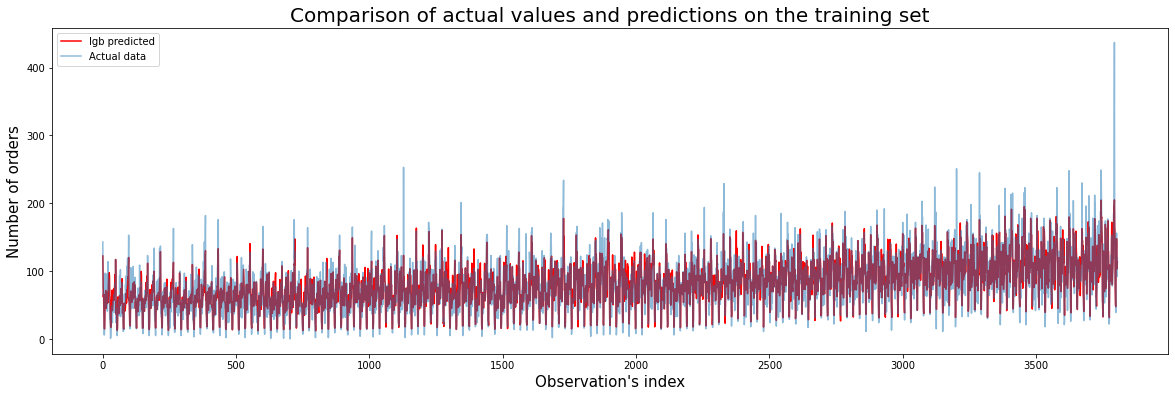

In [37]:
plt.figure(figsize=(20,6))
plt.plot(predictions_lgb_train, 'r', label='lgb predicted')
plt.title('Comparison of actual values and predictions on the training set', fontsize=20)
plt.xlabel("Observation's index", fontsize=15)
plt.ylabel('Number of orders', fontsize=15)
#actual data plot
plt.plot(target_train.values, label='Actual data', alpha=.5)
plt.legend();

### CatBoost

In [38]:
%%time
#model creating function, hyperparameters tuning with optuna
def objective_cb(trial):

    param = {
       'loss_function': 'RMSE',
       'learning_rate': trial.suggest_float('learning_rate', 0.01,0.1),
       'n_estimators': trial.suggest_int( "n_estimators",  40,300,20),
       'max_depth': trial.suggest_int( 'max_depth',  1,8,1),
       'random_seed': 42
       }
    
    model = CatBoostRegressor(**param, cat_features=['hour', 'day_of_week'], verbose=150)  
    
    scores = cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=cv_ts) 
   
    return scores.mean()

sampler = TPESampler(seed=42) #fixed sampler for optuna
study_cb = optuna.create_study(direction='maximize', sampler=sampler)
study_cb.optimize(objective_cb, n_trials=30)

#best tuned model
optimised_cb = CatBoostRegressor(max_depth=study_cb.best_params['max_depth'], learning_rate=study_cb.best_params['learning_rate'],
                                     n_estimators = study_cb.best_params['n_estimators'], random_seed=42, 
                                     loss_function='RMSE', cat_features=['hour', 'day_of_week'])

#fitting best model
optimised_cb.fit(features_train, target_train)

[I 2023-02-09 08:49:51,722] A new study created in memory with name: no-name-6eacf36e-1838-42b2-91e5-505c3e1d3332


0:	learn: 28.9943180	total: 58.2ms	remaining: 17.4s
150:	learn: 12.6294544	total: 1.17s	remaining: 1.15s
299:	learn: 9.8662319	total: 3.47s	remaining: 0us
0:	learn: 32.3227657	total: 13.1ms	remaining: 3.91s
150:	learn: 15.4403370	total: 1.97s	remaining: 1.94s
299:	learn: 13.2637351	total: 4.78s	remaining: 0us
0:	learn: 33.1074684	total: 14.1ms	remaining: 4.23s
150:	learn: 16.8002971	total: 3.46s	remaining: 3.41s


[I 2023-02-09 08:50:07,860] Trial 0 finished with value: -23.056693362518924 and parameters: {'learning_rate': 0.04370861069626263, 'n_estimators': 300, 'max_depth': 6}. Best is trial 0 with value: -23.056693362518924.


299:	learn: 15.1130584	total: 7.41s	remaining: 0us
0:	learn: 28.8355405	total: 12.3ms	remaining: 968ms
79:	learn: 16.3186587	total: 541ms	remaining: 0us
0:	learn: 32.1381472	total: 11.8ms	remaining: 930ms
79:	learn: 18.1489546	total: 469ms	remaining: 0us
0:	learn: 33.0670770	total: 6.28ms	remaining: 496ms


[I 2023-02-09 08:50:09,984] Trial 1 finished with value: -23.683533554883976 and parameters: {'learning_rate': 0.0638792635777333, 'n_estimators': 80, 'max_depth': 2}. Best is trial 0 with value: -23.056693362518924.


79:	learn: 18.9848482	total: 570ms	remaining: 0us
0:	learn: 29.4246950	total: 13.4ms	remaining: 3.75s
150:	learn: 16.6514746	total: 1.68s	remaining: 1.44s
279:	learn: 14.7192748	total: 3.31s	remaining: 0us
0:	learn: 32.8010357	total: 14.2ms	remaining: 3.97s
150:	learn: 18.5011046	total: 1.67s	remaining: 1.43s
279:	learn: 16.8938676	total: 3.39s	remaining: 0us
0:	learn: 33.6495835	total: 12.6ms	remaining: 3.51s
150:	learn: 19.4488451	total: 2.73s	remaining: 2.34s


[I 2023-02-09 08:50:21,650] Trial 2 finished with value: -23.231684410613592 and parameters: {'learning_rate': 0.015227525095137952, 'n_estimators': 280, 'max_depth': 5}. Best is trial 0 with value: -23.056693362518924.


279:	learn: 18.0349215	total: 4.56s	remaining: 0us
0:	learn: 28.6013893	total: 49.5ms	remaining: 1.93s
39:	learn: 14.0578522	total: 1.39s	remaining: 0us
0:	learn: 31.7334304	total: 32ms	remaining: 1.25s
39:	learn: 16.4044393	total: 1.15s	remaining: 0us
0:	learn: 32.5584019	total: 33.2ms	remaining: 1.29s


[I 2023-02-09 08:50:25,875] Trial 3 finished with value: -24.370265242280638 and parameters: {'learning_rate': 0.0737265320016441, 'n_estimators': 40, 'max_depth': 8}. Best is trial 0 with value: -23.056693362518924.


39:	learn: 17.7162328	total: 1.5s	remaining: 0us
0:	learn: 28.5727362	total: 1.22ms	remaining: 96.5ms
79:	learn: 15.8818815	total: 87.5ms	remaining: 0us
0:	learn: 31.8402325	total: 1.58ms	remaining: 125ms
79:	learn: 17.8668359	total: 116ms	remaining: 0us
0:	learn: 32.7918227	total: 1.87ms	remaining: 148ms
79:	learn: 18.6882791	total: 134ms	remaining: 0us


[I 2023-02-09 08:50:26,376] Trial 4 finished with value: -23.63384999377145 and parameters: {'learning_rate': 0.08491983767203796, 'n_estimators': 80, 'max_depth': 2}. Best is trial 0 with value: -23.056693362518924.


0:	learn: 29.2787946	total: 4.18ms	remaining: 497ms
119:	learn: 15.5621698	total: 500ms	remaining: 0us
0:	learn: 32.5984633	total: 5.25ms	remaining: 625ms
119:	learn: 17.5882455	total: 576ms	remaining: 0us
0:	learn: 33.4348136	total: 5.37ms	remaining: 639ms


[I 2023-02-09 08:50:28,319] Trial 5 finished with value: -23.57099533016817 and parameters: {'learning_rate': 0.026506405886809047, 'n_estimators': 120, 'max_depth': 5}. Best is trial 0 with value: -23.056693362518924.


119:	learn: 18.6235100	total: 689ms	remaining: 0us
0:	learn: 28.9659618	total: 3.96ms	remaining: 471ms
119:	learn: 13.8906188	total: 502ms	remaining: 0us
0:	learn: 32.2082916	total: 5.21ms	remaining: 621ms
119:	learn: 16.3273250	total: 581ms	remaining: 0us
0:	learn: 33.0248035	total: 5.36ms	remaining: 638ms


[I 2023-02-09 08:50:30,244] Trial 6 finished with value: -23.23994830785145 and parameters: {'learning_rate': 0.048875051677790424, 'n_estimators': 120, 'max_depth': 5}. Best is trial 0 with value: -23.056693362518924.


119:	learn: 17.6691890	total: 666ms	remaining: 0us
0:	learn: 29.3581864	total: 1.91ms	remaining: 227ms
119:	learn: 17.0025716	total: 222ms	remaining: 0us
0:	learn: 32.6985863	total: 2.44ms	remaining: 290ms
119:	learn: 18.8123140	total: 301ms	remaining: 0us
0:	learn: 33.5894725	total: 2.8ms	remaining: 333ms


[I 2023-02-09 08:50:31,231] Trial 7 finished with value: -24.55157552499706 and parameters: {'learning_rate': 0.022554447458683766, 'n_estimators': 120, 'max_depth': 3}. Best is trial 0 with value: -23.056693362518924.


119:	learn: 19.7276624	total: 296ms	remaining: 0us
0:	learn: 28.9975224	total: 1.39ms	remaining: 333ms
150:	learn: 15.7966166	total: 184ms	remaining: 109ms
239:	learn: 14.9973235	total: 281ms	remaining: 0us
0:	learn: 32.3217703	total: 1.71ms	remaining: 409ms
150:	learn: 17.4843712	total: 239ms	remaining: 141ms
239:	learn: 16.8453223	total: 389ms	remaining: 0us
0:	learn: 33.2368720	total: 2.05ms	remaining: 489ms


[I 2023-02-09 08:50:32,541] Trial 8 finished with value: -23.62282117336837 and parameters: {'learning_rate': 0.05104629857953324, 'n_estimators': 240, 'max_depth': 2}. Best is trial 0 with value: -23.056693362518924.


150:	learn: 18.4669492	total: 291ms	remaining: 172ms
239:	learn: 18.0201130	total: 446ms	remaining: 0us
0:	learn: 29.2030885	total: 770us	remaining: 153ms
150:	learn: 16.4424350	total: 184ms	remaining: 59.8ms
199:	learn: 16.1080594	total: 299ms	remaining: 0us
0:	learn: 32.5029253	total: 1.8ms	remaining: 358ms
150:	learn: 18.3330418	total: 302ms	remaining: 98.1ms
199:	learn: 17.9869051	total: 417ms	remaining: 0us
0:	learn: 33.2961157	total: 2.02ms	remaining: 401ms


[I 2023-02-09 08:50:34,042] Trial 9 finished with value: -23.686980702542808 and parameters: {'learning_rate': 0.05628109945722505, 'n_estimators': 200, 'max_depth': 1}. Best is trial 0 with value: -23.056693362518924.


150:	learn: 19.1070601	total: 440ms	remaining: 143ms
199:	learn: 18.8238706	total: 556ms	remaining: 0us
0:	learn: 28.3352999	total: 42.8ms	remaining: 12.8s
150:	learn: 6.4777414	total: 4.6s	remaining: 4.54s
299:	learn: 2.6777391	total: 8.53s	remaining: 0us
0:	learn: 31.5170763	total: 35.1ms	remaining: 10.5s
150:	learn: 10.3913480	total: 6.67s	remaining: 6.58s
299:	learn: 6.1322383	total: 13.7s	remaining: 0us
0:	learn: 32.1854967	total: 69.2ms	remaining: 20.7s
150:	learn: 12.3290835	total: 8.08s	remaining: 7.97s


[I 2023-02-09 08:51:10,455] Trial 10 finished with value: -24.08799974995848 and parameters: {'learning_rate': 0.09506228898073482, 'n_estimators': 300, 'max_depth': 8}. Best is trial 0 with value: -23.056693362518924.


299:	learn: 8.2088387	total: 13.9s	remaining: 0us
0:	learn: 29.4916273	total: 8.78ms	remaining: 2.63s
150:	learn: 17.7879439	total: 1.6s	remaining: 1.58s
299:	learn: 15.0285264	total: 3.72s	remaining: 0us
0:	learn: 32.8829729	total: 8.45ms	remaining: 2.52s
150:	learn: 19.6788964	total: 1.28s	remaining: 1.27s
299:	learn: 17.1235331	total: 2.53s	remaining: 0us
0:	learn: 33.7245447	total: 10.1ms	remaining: 3.02s
150:	learn: 20.4054384	total: 1.45s	remaining: 1.43s


[I 2023-02-09 08:51:19,827] Trial 11 finished with value: -23.819176826989786 and parameters: {'learning_rate': 0.0106866559688885, 'n_estimators': 300, 'max_depth': 6}. Best is trial 0 with value: -23.056693362518924.


299:	learn: 18.2063960	total: 2.83s	remaining: 0us
0:	learn: 29.0962042	total: 7.19ms	remaining: 1.86s
150:	learn: 13.3050284	total: 1.09s	remaining: 787ms
259:	learn: 11.4024592	total: 1.86s	remaining: 0us
0:	learn: 32.4375103	total: 8.59ms	remaining: 2.22s
150:	learn: 15.7790311	total: 1.3s	remaining: 942ms
259:	learn: 14.4917652	total: 2.33s	remaining: 0us
0:	learn: 33.2338835	total: 31ms	remaining: 8.02s
150:	learn: 17.1333583	total: 2.94s	remaining: 2.12s


[I 2023-02-09 08:51:28,832] Trial 12 finished with value: -23.145639905221756 and parameters: {'learning_rate': 0.036903987841000796, 'n_estimators': 260, 'max_depth': 6}. Best is trial 0 with value: -23.056693362518924.


259:	learn: 16.0652731	total: 4.52s	remaining: 0us
0:	learn: 29.0504954	total: 20.1ms	remaining: 4.8s
150:	learn: 12.0264680	total: 2.64s	remaining: 1.55s
239:	learn: 10.2633741	total: 3.69s	remaining: 0us
0:	learn: 32.3623604	total: 18.7ms	remaining: 4.47s
150:	learn: 14.7666157	total: 2.13s	remaining: 1.26s
239:	learn: 13.4275810	total: 3.39s	remaining: 0us
0:	learn: 33.1487991	total: 15.7ms	remaining: 3.75s
150:	learn: 16.2564838	total: 3.87s	remaining: 2.28s


[I 2023-02-09 08:51:41,422] Trial 13 finished with value: -23.125962561083682 and parameters: {'learning_rate': 0.04127702984789998, 'n_estimators': 240, 'max_depth': 7}. Best is trial 0 with value: -23.056693362518924.


239:	learn: 15.1054850	total: 5.23s	remaining: 0us
0:	learn: 29.0940074	total: 11.8ms	remaining: 2.59s
150:	learn: 12.3621495	total: 1.79s	remaining: 817ms
219:	learn: 10.8238176	total: 2.62s	remaining: 0us
0:	learn: 32.4130617	total: 14.6ms	remaining: 3.2s
150:	learn: 14.9290805	total: 2.16s	remaining: 985ms
219:	learn: 13.7855337	total: 3.14s	remaining: 0us
0:	learn: 33.2048207	total: 15.6ms	remaining: 3.41s
150:	learn: 16.4061916	total: 4.52s	remaining: 2.06s


[I 2023-02-09 08:51:53,932] Trial 14 finished with value: -23.14596918211331 and parameters: {'learning_rate': 0.03827827508899313, 'n_estimators': 220, 'max_depth': 7}. Best is trial 0 with value: -23.056693362518924.


219:	learn: 15.4922804	total: 6.49s	remaining: 0us
0:	learn: 29.0886722	total: 15.7ms	remaining: 3.12s
150:	learn: 12.0752675	total: 1.87s	remaining: 606ms
199:	learn: 11.0091760	total: 2.47s	remaining: 0us
0:	learn: 32.4068448	total: 14.1ms	remaining: 2.81s
150:	learn: 14.8567867	total: 2.18s	remaining: 707ms
199:	learn: 14.1082102	total: 2.84s	remaining: 0us
0:	learn: 33.1979515	total: 15.5ms	remaining: 3.08s
150:	learn: 16.3698462	total: 2.42s	remaining: 786ms


[I 2023-02-09 08:52:02,658] Trial 15 finished with value: -23.245454934971367 and parameters: {'learning_rate': 0.03864576251123272, 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: -23.056693362518924.


199:	learn: 15.7048743	total: 3.18s	remaining: 0us
0:	learn: 28.6687417	total: 3.38ms	remaining: 876ms
150:	learn: 13.5221605	total: 960ms	remaining: 693ms
259:	learn: 11.4413821	total: 1.77s	remaining: 0us
0:	learn: 32.0117579	total: 6.76ms	remaining: 1.75s
150:	learn: 15.8996686	total: 1.33s	remaining: 962ms
259:	learn: 14.5428698	total: 1.73s	remaining: 0us
0:	learn: 32.7789787	total: 4.44ms	remaining: 1.15s
150:	learn: 17.2162175	total: 651ms	remaining: 470ms


[I 2023-02-09 08:52:07,542] Trial 16 finished with value: -23.676403191419954 and parameters: {'learning_rate': 0.06470489624788044, 'n_estimators': 260, 'max_depth': 4}. Best is trial 0 with value: -23.056693362518924.


259:	learn: 16.1255936	total: 1.1s	remaining: 0us
0:	learn: 29.2169877	total: 14.8ms	remaining: 2.35s
150:	learn: 12.8903274	total: 1.71s	remaining: 102ms
159:	learn: 12.6816334	total: 1.81s	remaining: 0us
0:	learn: 32.4955782	total: 12.6ms	remaining: 2s
150:	learn: 15.6180998	total: 1.98s	remaining: 118ms
159:	learn: 15.4646201	total: 2.09s	remaining: 0us
0:	learn: 33.3511057	total: 15.5ms	remaining: 2.46s


[I 2023-02-09 08:52:13,949] Trial 17 finished with value: -23.556457117702042 and parameters: {'learning_rate': 0.030608885584038913, 'n_estimators': 160, 'max_depth': 7}. Best is trial 0 with value: -23.056693362518924.


150:	learn: 16.8686011	total: 2.14s	remaining: 128ms
159:	learn: 16.7539297	total: 2.28s	remaining: 0us
0:	learn: 28.9333450	total: 7.39ms	remaining: 1.76s
150:	learn: 12.4696916	total: 1.05s	remaining: 620ms
239:	learn: 10.5531350	total: 1.68s	remaining: 0us
0:	learn: 32.2541050	total: 9.01ms	remaining: 2.15s
150:	learn: 15.2201685	total: 3.04s	remaining: 1.79s
239:	learn: 13.9454417	total: 3.79s	remaining: 0us
0:	learn: 33.0318189	total: 9.64ms	remaining: 2.3s
150:	learn: 16.5472076	total: 1.42s	remaining: 838ms


[I 2023-02-09 08:52:21,945] Trial 18 finished with value: -23.248471902406184 and parameters: {'learning_rate': 0.04779080303925225, 'n_estimators': 240, 'max_depth': 6}. Best is trial 0 with value: -23.056693362518924.


239:	learn: 15.4520569	total: 2.27s	remaining: 0us
0:	learn: 29.1184083	total: 2.96ms	remaining: 530ms
150:	learn: 14.6280810	total: 416ms	remaining: 79.8ms
179:	learn: 14.2840142	total: 488ms	remaining: 0us
0:	learn: 32.3573180	total: 3.53ms	remaining: 632ms
150:	learn: 16.7822137	total: 493ms	remaining: 94.7ms
179:	learn: 16.4670036	total: 584ms	remaining: 0us
0:	learn: 33.2583561	total: 3.89ms	remaining: 697ms


[I 2023-02-09 08:52:23,881] Trial 19 finished with value: -23.117564706743636 and parameters: {'learning_rate': 0.040851935943968465, 'n_estimators': 180, 'max_depth': 4}. Best is trial 0 with value: -23.056693362518924.


150:	learn: 17.9844242	total: 560ms	remaining: 107ms
179:	learn: 17.7963870	total: 659ms	remaining: 0us
0:	learn: 29.3716158	total: 3.03ms	remaining: 482ms
150:	learn: 16.0284557	total: 418ms	remaining: 24.9ms
159:	learn: 15.8850716	total: 441ms	remaining: 0us
0:	learn: 32.6925680	total: 3.37ms	remaining: 535ms
150:	learn: 17.9219628	total: 503ms	remaining: 30ms
159:	learn: 17.7782229	total: 532ms	remaining: 0us
0:	learn: 33.5740782	total: 3.82ms	remaining: 608ms


[I 2023-02-09 08:52:25,642] Trial 20 finished with value: -23.552924448734306 and parameters: {'learning_rate': 0.021428635960097808, 'n_estimators': 160, 'max_depth': 4}. Best is trial 0 with value: -23.056693362518924.


150:	learn: 18.9047863	total: 556ms	remaining: 33.1ms
159:	learn: 18.7907667	total: 587ms	remaining: 0us
0:	learn: 29.0230903	total: 7.14ms	remaining: 1.42s
150:	learn: 12.8903907	total: 1.06s	remaining: 344ms
199:	learn: 12.0786369	total: 1.39s	remaining: 0us
0:	learn: 32.3551677	total: 8.54ms	remaining: 1.7s
150:	learn: 15.5713259	total: 1.29s	remaining: 419ms
199:	learn: 14.8865107	total: 1.83s	remaining: 0us
0:	learn: 33.1431671	total: 15.1ms	remaining: 3.01s
150:	learn: 16.9301785	total: 2.81s	remaining: 913ms


[I 2023-02-09 08:52:32,383] Trial 21 finished with value: -23.090614324552103 and parameters: {'learning_rate': 0.04178489758823909, 'n_estimators': 200, 'max_depth': 6}. Best is trial 0 with value: -23.056693362518924.


199:	learn: 16.3541064	total: 3.27s	remaining: 0us
0:	learn: 29.1816226	total: 3.06ms	remaining: 608ms
150:	learn: 15.1357964	total: 460ms	remaining: 149ms
199:	learn: 14.5683002	total: 614ms	remaining: 0us
0:	learn: 32.5602096	total: 3.88ms	remaining: 773ms
150:	learn: 17.2407304	total: 570ms	remaining: 185ms
199:	learn: 16.7755849	total: 744ms	remaining: 0us
0:	learn: 33.3759282	total: 4.4ms	remaining: 876ms
150:	learn: 18.2701954	total: 666ms	remaining: 216ms


[I 2023-02-09 08:52:34,863] Trial 22 finished with value: -23.251468931890354 and parameters: {'learning_rate': 0.030777621346817684, 'n_estimators': 200, 'max_depth': 4}. Best is trial 0 with value: -23.056693362518924.


199:	learn: 17.8878264	total: 880ms	remaining: 0us
0:	learn: 29.0257717	total: 6.4ms	remaining: 1.15s
150:	learn: 12.6259521	total: 972ms	remaining: 187ms
179:	learn: 11.9866379	total: 1.15s	remaining: 0us
0:	learn: 32.2496522	total: 7.79ms	remaining: 1.39s
150:	learn: 15.3360131	total: 1.16s	remaining: 223ms
179:	learn: 14.9374773	total: 1.38s	remaining: 0us
0:	learn: 33.0805687	total: 10.6ms	remaining: 1.89s
150:	learn: 16.7808586	total: 1.29s	remaining: 247ms


[I 2023-02-09 08:52:39,151] Trial 23 finished with value: -23.52287574231039 and parameters: {'learning_rate': 0.04501213599483925, 'n_estimators': 180, 'max_depth': 6}. Best is trial 0 with value: -23.056693362518924.


179:	learn: 16.4782858	total: 1.52s	remaining: 0us
0:	learn: 28.9518833	total: 1.94ms	remaining: 270ms
139:	learn: 14.9706925	total: 251ms	remaining: 0us
0:	learn: 32.1935318	total: 2.42ms	remaining: 337ms
139:	learn: 16.9514369	total: 318ms	remaining: 0us
0:	learn: 33.1274353	total: 2.71ms	remaining: 376ms


[I 2023-02-09 08:52:40,245] Trial 24 finished with value: -23.38213787231886 and parameters: {'learning_rate': 0.05399391909739641, 'n_estimators': 140, 'max_depth': 3}. Best is trial 0 with value: -23.056693362518924.


139:	learn: 18.1570442	total: 342ms	remaining: 0us
0:	learn: 29.1386395	total: 4.65ms	remaining: 1.02s
150:	learn: 14.2802866	total: 684ms	remaining: 313ms
219:	learn: 13.2660299	total: 996ms	remaining: 0us
0:	learn: 32.4706556	total: 6.02ms	remaining: 1.32s
150:	learn: 16.5723757	total: 1.86s	remaining: 851ms
219:	learn: 15.8127306	total: 2.91s	remaining: 0us
0:	learn: 33.3048132	total: 16.4ms	remaining: 3.59s
150:	learn: 17.7375964	total: 1.04s	remaining: 474ms


[I 2023-02-09 08:52:45,896] Trial 25 finished with value: -23.09204566912048 and parameters: {'learning_rate': 0.03436187664072553, 'n_estimators': 220, 'max_depth': 5}. Best is trial 0 with value: -23.056693362518924.


219:	learn: 17.1369438	total: 1.47s	remaining: 0us
0:	learn: 29.1556278	total: 4.8ms	remaining: 1.34s
150:	learn: 14.3446019	total: 665ms	remaining: 568ms
279:	learn: 12.6102747	total: 1.24s	remaining: 0us
0:	learn: 32.4902731	total: 5.73ms	remaining: 1.6s
150:	learn: 16.6360487	total: 861ms	remaining: 736ms
279:	learn: 15.2710301	total: 1.59s	remaining: 0us
0:	learn: 33.3252849	total: 6.22ms	remaining: 1.73s
150:	learn: 17.8178197	total: 926ms	remaining: 791ms


[I 2023-02-09 08:52:50,690] Trial 26 finished with value: -22.9887554907689 and parameters: {'learning_rate': 0.03322086956583535, 'n_estimators': 280, 'max_depth': 5}. Best is trial 26 with value: -22.9887554907689.


279:	learn: 16.8577338	total: 1.7s	remaining: 0us
0:	learn: 29.1875692	total: 7.07ms	remaining: 1.97s
150:	learn: 13.7396645	total: 1.08s	remaining: 920ms
279:	learn: 11.6825433	total: 1.99s	remaining: 0us
0:	learn: 32.5404182	total: 8.45ms	remaining: 2.36s
150:	learn: 16.1409692	total: 1.3s	remaining: 1.11s
279:	learn: 14.7727476	total: 3.28s	remaining: 0us
0:	learn: 33.3472483	total: 18.1ms	remaining: 5.04s
150:	learn: 17.3950706	total: 2.13s	remaining: 1.82s


[I 2023-02-09 08:52:59,662] Trial 27 finished with value: -23.137976921537888 and parameters: {'learning_rate': 0.030819581852004566, 'n_estimators': 280, 'max_depth': 6}. Best is trial 26 with value: -22.9887554907689.


279:	learn: 16.2688955	total: 3.39s	remaining: 0us
0:	learn: 28.9938993	total: 4.71ms	remaining: 1.31s
150:	learn: 13.5889194	total: 755ms	remaining: 645ms
279:	learn: 11.3984347	total: 1.33s	remaining: 0us
0:	learn: 32.3035322	total: 5.67ms	remaining: 1.58s
150:	learn: 16.0724960	total: 2.48s	remaining: 2.12s
279:	learn: 14.6103184	total: 4.12s	remaining: 0us
0:	learn: 33.1304141	total: 33.5ms	remaining: 9.34s
150:	learn: 17.3883731	total: 1.09s	remaining: 935ms


[I 2023-02-09 08:53:07,421] Trial 28 finished with value: -22.964374190599802 and parameters: {'learning_rate': 0.04410771886482657, 'n_estimators': 280, 'max_depth': 5}. Best is trial 28 with value: -22.964374190599802.


279:	learn: 16.1925668	total: 1.88s	remaining: 0us
0:	learn: 28.7772648	total: 6ms	remaining: 1.67s
150:	learn: 12.8647740	total: 1.54s	remaining: 1.32s
279:	learn: 10.0570206	total: 2.86s	remaining: 0us
0:	learn: 32.0534555	total: 5.65ms	remaining: 1.58s
150:	learn: 15.6079495	total: 839ms	remaining: 717ms
279:	learn: 13.6064628	total: 1.55s	remaining: 0us
0:	learn: 32.8694562	total: 6.27ms	remaining: 1.75s
150:	learn: 16.9544183	total: 913ms	remaining: 780ms


[I 2023-02-09 08:53:13,806] Trial 29 finished with value: -23.21621560317676 and parameters: {'learning_rate': 0.058778454975611114, 'n_estimators': 280, 'max_depth': 5}. Best is trial 28 with value: -22.964374190599802.


279:	learn: 15.4086007	total: 1.69s	remaining: 0us
0:	learn: 37.7052374	total: 7.26ms	remaining: 2.03s
1:	learn: 36.8183636	total: 14.8ms	remaining: 2.06s
2:	learn: 35.9524168	total: 21.7ms	remaining: 2s
3:	learn: 35.2096418	total: 29.2ms	remaining: 2.01s
4:	learn: 34.4457002	total: 36.3ms	remaining: 2s
5:	learn: 33.6870484	total: 43.8ms	remaining: 2s
6:	learn: 32.9846510	total: 51.4ms	remaining: 2s
7:	learn: 32.3166401	total: 58.6ms	remaining: 1.99s
8:	learn: 31.6442774	total: 65.7ms	remaining: 1.98s
9:	learn: 31.0774789	total: 73.2ms	remaining: 1.98s
10:	learn: 30.5255680	total: 80.4ms	remaining: 1.97s
11:	learn: 29.9962837	total: 87.9ms	remaining: 1.96s
12:	learn: 29.4786828	total: 95.3ms	remaining: 1.96s
13:	learn: 28.9803684	total: 102ms	remaining: 1.95s
14:	learn: 28.5217068	total: 110ms	remaining: 1.94s
15:	learn: 28.1038524	total: 117ms	remaining: 1.94s
16:	learn: 27.7351029	total: 125ms	remaining: 1.93s
17:	learn: 27.3364378	total: 132ms	remaining: 1.93s
18:	learn: 26.9758855	

In [39]:
predictions_cb_train = optimised_cb.predict(features_train)

In [40]:
print(f'RMSE on training set: {mean_squared_error(target_train, predictions_cb_train, squared=False)}')
print(f'MAE on training set: {mean_absolute_error(target_train, predictions_cb_train)}')

RMSE on training set: 18.32438524309465
MAE on training set: 14.0403883389043


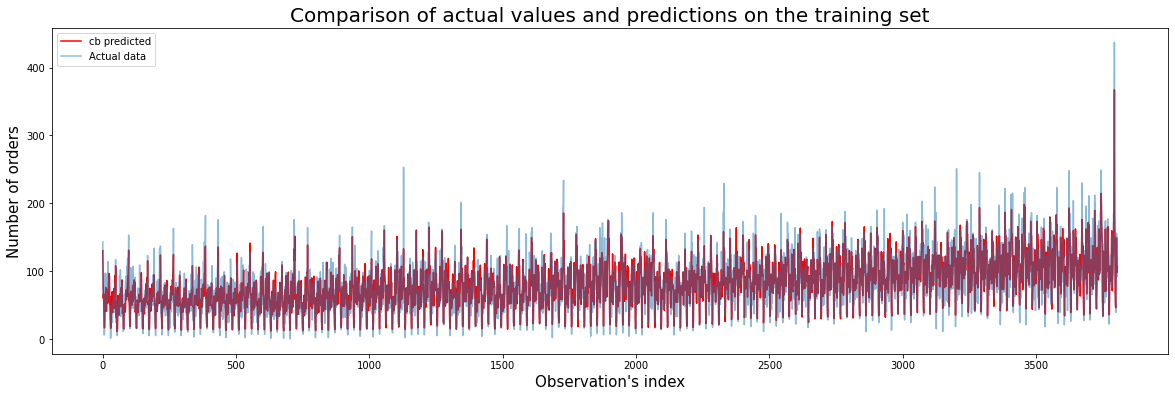

In [41]:
plt.figure(figsize=(20,6))
plt.plot(predictions_cb_train, 'r', label='cb predicted')
plt.title('Comparison of actual values and predictions on the training set', fontsize=20)
plt.xlabel("Observation's index", fontsize=15)
plt.ylabel('Number of orders', fontsize=15)
#actual data plot
plt.plot(target_train.values, label='Actual data', alpha=.5)
plt.legend();

### Facebook Prophet

In [42]:
#merging features and target for fbprophet, keeping only dates and amount of orders
data_train_pr = (features_train.merge(target_train.to_frame(), left_index=True, right_index=True)
                 .reset_index())
data_train_pr = data_train_pr[['datetime', 'num_orders']]
data_train_pr.rename(columns={"datetime": "ds", "num_orders": "y"}, inplace=True)

In [43]:
data_train_pr

,ds,y
0,2018-03-08 00:00:00,143
1,2018-03-08 01:00:00,78
2,2018-03-08 02:00:00,65
3,2018-03-08 03:00:00,68
4,2018-03-08 04:00:00,60
...,...,...
3801,2018-08-13 09:00:00,137
3802,2018-08-13 10:00:00,156
3803,2018-08-13 11:00:00,144
3804,2018-08-13 12:00:00,92


In [44]:
#checking indexes in timeseriesplit for identical cross-validation
for train_index, test_index in cv_ts.split(features_train):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [45]:
#checking time deltas for the initial set and how much time is added next in the training set
print((features_train.index.values[952] - features_train.index.values[0]).astype('timedelta64[h]'))
print((features_train.index.values[1903] - features_train.index.values[0]).astype('timedelta64[h]'))
print((features_train.index.values[2854] - features_train.index.values[0]).astype('timedelta64[h]'))

952 hours
1903 hours
2854 hours


Each split adds 951 hours to the training set. Now let's analyze the model's prediction period.

In [46]:
print((features_train.index.values[1903] - features_train.index.values[953]).astype('timedelta64[h]'))
print((features_train.index.values[2854] - features_train.index.values[1904]).astype('timedelta64[h]'))
print((features_train.index.values[3805] - features_train.index.values[2855]).astype('timedelta64[h]'))

950 hours
950 hours
950 hours


Models predict values for the next 950 hours. These measurements are required for proper cross-validation with Prophet, which should be identical to previous models.

In [47]:
%%time
#params grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

#generating all params combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  #rmse list for every combination

#starting cross-validation for every combination with initial training set of 952 hours,
#period of 951 hours (how much time is added in the training set) and forecast horizon (950 hours)
for params in all_params:
    m = Prophet(**params).fit(data_train_pr)
    df_cv = cross_validation(m, initial='952 hours', period='951 hours', horizon = '950 hours', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

#best params
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results.sort_values(by='rmse', ascending=False))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpudx2842o/kgy78vno.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpudx2842o/yaew0_n9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59985', 'data', 'file=/tmp/tmpudx2842o/kgy78vno.json', 'init=/tmp/tmpudx2842o/yaew0_n9.json', 'output', 'file=/tmp/tmpudx2842o/prophet_modelc8swga6t/prophet_model-20230209085317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:53:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:53:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 3 forecasts with cutoffs between 2018-04-16 17:00:00 and 2018-07-04 23:00:00
INFO:prophet:Applying in parallel with <conc

    changepoint_prior_scale  seasonality_prior_scale       rmse
12                    0.500                     0.01  33.092858
13                    0.500                     0.10  32.812274
15                    0.500                    10.00  32.808472
14                    0.500                     1.00  32.794472
8                     0.100                     0.01  31.176057
11                    0.100                    10.00  31.009489
10                    0.100                     1.00  30.807388
9                     0.100                     0.10  30.795641
0                     0.001                     0.01  29.184065
1                     0.001                     0.10  29.113879
3                     0.001                    10.00  28.860721
4                     0.010                     0.01  28.552219
5                     0.010                     0.10  28.305721
6                     0.010                     1.00  28.238627
7                     0.010             

### Conclusions

* **The best result was demonstrated by CatBoost on the training set. The RMSE on the training set is ~18.32, while the MAE is ~14.04, i.e. the model is wrong on average by 14.04 orders. Thus, CatBoost should be tested on the test set. However, the models built can be improved in the future. For example, it is possible to analyze historical data on the number of arrivals and departures from airports with the type of aircraft (the goal is to determine an approximate number of passengers) and feed this number into the model as a feature.** 

## Checking best model on the test set

In [48]:
predictions_cb_test = optimised_cb.predict(features_test)

In [49]:
print(f'RMSE on the test set: {mean_squared_error(target_test, predictions_cb_test, squared=False)}')
print(f'MAE on the test set: {mean_absolute_error(target_test, predictions_cb_test)}')

RMSE on the test set: 37.23962212012806
MAE on the test set: 26.50421585205641


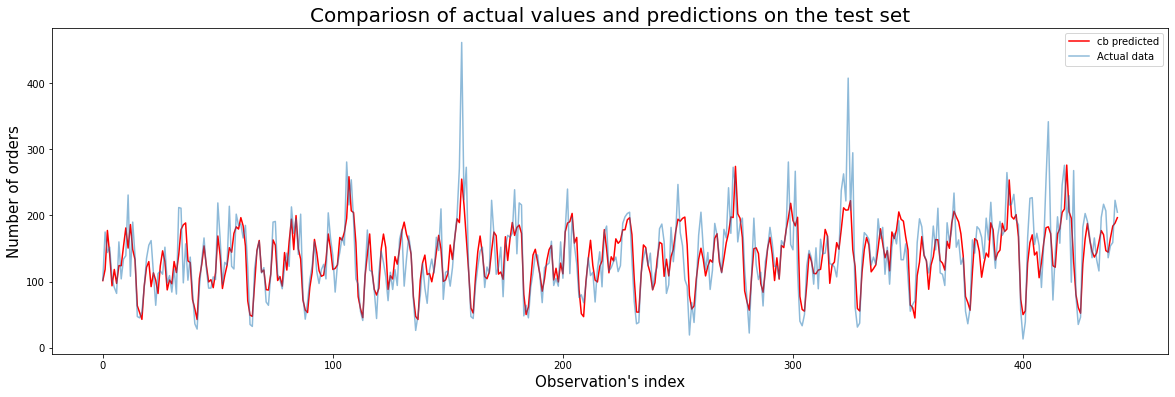

In [50]:
plt.figure(figsize=(20,6))
plt.plot(predictions_cb_test, 'r', label='cb predicted')
plt.title('Compariosn of actual values and predictions on the test set', fontsize=20)
plt.xlabel("Observation's index", fontsize=15)
plt.ylabel('Number of orders', fontsize=15)
#actual data plot
plt.plot(target_test.values, label='Actual data', alpha=.5)
plt.legend();

The model generally predicts the series well, but does not fully capture the peaks.

## Summary

* **A quick data analysis shows that the original dataset is characterized by 10-minute intervals. Considering that the task is to predict the number of taxi orders for the next hour, the data has been resampled into 1-hour intervals with the sum of orders for each hour. There are no missing values in the dataset and the data are monotonous. The first observation is on March 1, 2018, and the last one is on August 31 of the same year. The time delta is 183 days and 23 hours;**
* **Throughout the research horizon (March 2018-August 2018), there is a trend towards an increase in the volume of orders at airports. The decomposition of the series into components confirms the thesis of a growing trend. Taxi order volumes are characterized by weekly and daily seasonality. Thus, peaks occur at the end of the week (Friday) and the beginning of the week (Monday), and order volumes decline from midnight to ~6 am. From about 6 am to midnight, the growth of taxi orders begins, with peaks around 9:00 am, 4:00 pm, and midnight. The following features were created: hour of the order and day of the week because the data contains daily and weekly seasonalities, lagging and moving averages values;**
* **CatBoost performed best on the training set. The RMSE on the training set is ~18.32, while the MAE is ~14.04, i.e. the model is wrong on average by 14.04 orders. The RMSE on the test set is ~37.24, while the MAE is ~26.50. However, the built models can be improved in the future. For example, it is possible to analyze historical data on the number of arrivals and departures from airports with the type of aircraft (the goal is to determine an approximate number of passengers) and feed this number into the model as a feature.**